<a href="https://colab.research.google.com/github/JCLC9027/Proyecto_integrador_18/blob/main/Avance3_18equipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

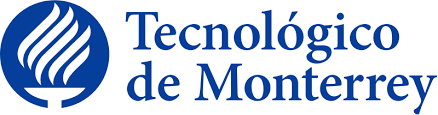

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Procesamiento de Lenguaje Natural (NLP)**
###Tecnológico de Monterrey
###Asesor: Luis Eduardo Falcón Morales
## **Avance 3. Baseline**
###**Equipo 18:**
###**A01793052 - Juan Carlos Lopez Cruz**


## **Website description**:

ConsumerAffairs is a rapidly growing online marketplace where each month millions of consumers research purchases, connect with brands, transact, write reviews and stay up to date on important consumer news.

Brands utilize our software-as-a-service platform to connect with customers, collect reviews and generate sales.

ConsumerAffairs has a creative, driven and fast-paced entrepreneurial environment. We are looking for teammates that want to win, are self-motivated, high performing and who yearn to build something big.

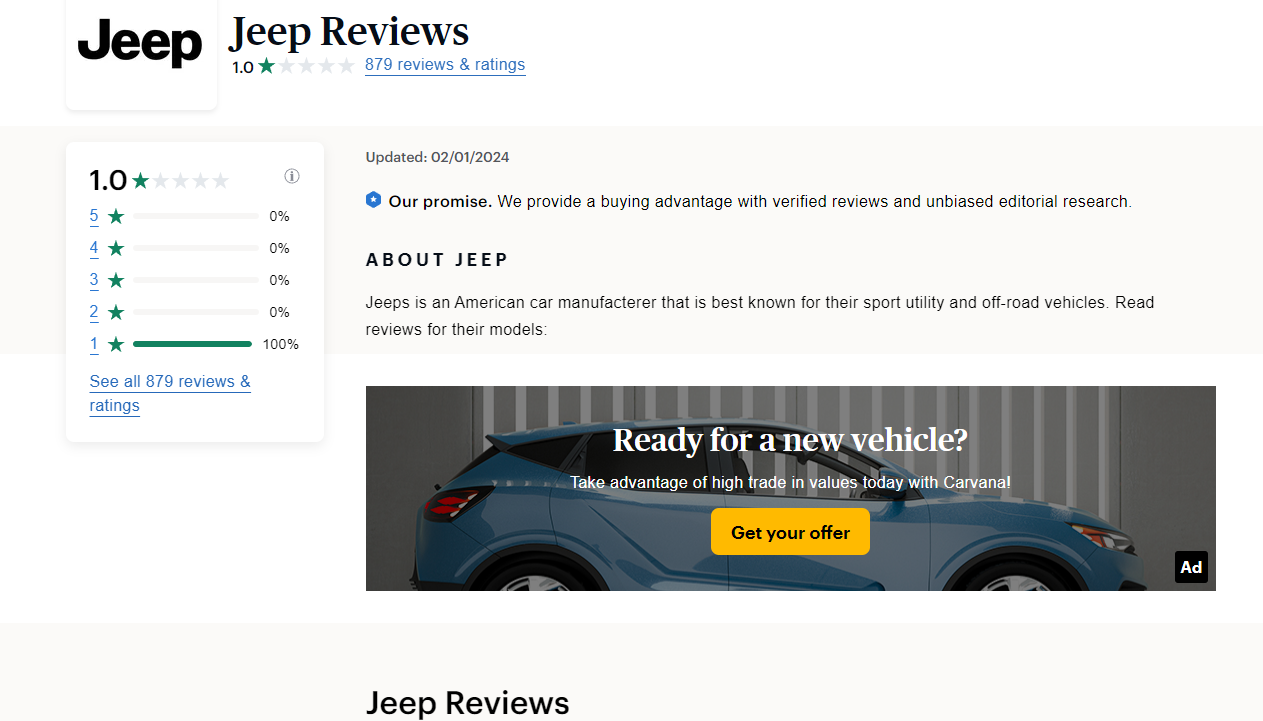

## **Libraries to install**

In [ ]:
!pip install transformers datasets evaluate accelerate

## **Libraries to be used**

In [ ]:
import torch
import requests
from bs4 import BeautifulSoup as soup
from random import randint
from time import sleep
from datasets import Dataset, load_dataset, DatasetDict
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import files
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF Matrix

##import fasttext
##import fasttext.util

from evaluate import evaluator
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer, pipeline
from transformers import AutoConfig
from datasets import Dataset, load_dataset, DatasetDict, load_metric



# <font color='red'>**Web Scrapping part** - No recommendable to run again</font>

Web scraping refers to the extraction of data from a website. This information is collected and then exported into a format that is more useful for the user. Be it a spreadsheet or an API.


## **1-First let's Check if the web site allows to perform Webscrapping and links Generation :**



Prints the status of the HTTP request for each URL, which includes the response status code (like 200 for success, 404 for not found, etc.).

In [ ]:
url1 = 'https://www.consumeraffairs.com/automotive/jeep.htm?page=2#scroll_to_reviews=true' ## Jeep brand 7 pages
url2= 'https://www.consumeraffairs.com/automotive/jeep-cherokee.html?page=2#scroll_to_reviews=true' ## Jeep Cherokee 3 pages
url3= 'https://www.consumeraffairs.com/automotive/jeep-wrangler.html?page=2#scroll_to_reviews=true' ## Jeep Wrangler. 3 pages
url4 = 'https://www.consumeraffairs.com/automotive/jeep-grand-cherokee.html?page=2#scroll_to_reviews=true' ## Jeep gran cherokee 4 pages
urls=[url1,url2,url3,url4]
for url in urls:
    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0 (X11; CrOS x86_64 12871.102.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.141 Safari/537.36"})
    print(f"URL: {url}, Status Code: {response.status_code}")

URL: https://www.consumeraffairs.com/automotive/jeep.htm?page=2#scroll_to_reviews=true, Status Code: 200
URL: https://www.consumeraffairs.com/automotive/jeep-cherokee.html?page=2#scroll_to_reviews=true, Status Code: 200
URL: https://www.consumeraffairs.com/automotive/jeep-wrangler.html?page=2#scroll_to_reviews=true, Status Code: 200
URL: https://www.consumeraffairs.com/automotive/jeep-grand-cherokee.html?page=2#scroll_to_reviews=true, Status Code: 200


Generation of the Links to extract all the comments from website realate to Jeep brand

In [ ]:
links = []
Pages=[7,3,3,4]
urls=[url1,url2,url3,url4]
reviews_x_pages = 1    # The pages are changing 1 by 1.

for i, url in enumerate(urls):
  for k in range(1, Pages[i]+1, reviews_x_pages):
    a = url
    if k == 1:
      a=a.replace("page=2","")     # for the first page there is not page number
    else:
      ss = str(k)  # convertimos a string el valor numérico.
      a=a.replace("2",ss)
    links.append(a)


links

['https://www.consumeraffairs.com/automotive/jeep.htm?#scroll_to_reviews=true',
 'https://www.consumeraffairs.com/automotive/jeep.htm?page=2#scroll_to_reviews=true',
 'https://www.consumeraffairs.com/automotive/jeep.htm?page=3#scroll_to_reviews=true',
 'https://www.consumeraffairs.com/automotive/jeep.htm?page=4#scroll_to_reviews=true',
 'https://www.consumeraffairs.com/automotive/jeep.htm?page=5#scroll_to_reviews=true',
 'https://www.consumeraffairs.com/automotive/jeep.htm?page=6#scroll_to_reviews=true',
 'https://www.consumeraffairs.com/automotive/jeep.htm?page=7#scroll_to_reviews=true',
 'https://www.consumeraffairs.com/automotive/jeep-cherokee.html?#scroll_to_reviews=true',
 'https://www.consumeraffairs.com/automotive/jeep-cherokee.html?page=2#scroll_to_reviews=true',
 'https://www.consumeraffairs.com/automotive/jeep-cherokee.html?page=3#scroll_to_reviews=true',
 'https://www.consumeraffairs.com/automotive/jeep-wrangler.html?#scroll_to_reviews=true',
 'https://www.consumeraffairs.co

## **2- The next step is to extract the comments of the reviewd from each page.**

The following Code extract the data from the Webside.
- The list **review** storages all the comments.
- The list **stars** storages all the rates.

These lists are storage in a data frame **ds**.

In [ ]:
# The following Code is to extract the comments from
#https://www.consumeraffairs.com/automotive/jeep.htm   (7 pages)
#https://www.consumeraffairs.com/automotive/jeep-cherokee.html (3 pages)
#https://www.consumeraffairs.com/automotive/jeep-wrangler.html  (3 pages)
#https://www.consumeraffairs.com/automotive/jeep-grand-cherokee.html  (4 pages)

reviews = [] # This list will include the comments from web scrapping in the first run
review_text= [] # This list that we will use to storage the final comments
stars =[] # This list will storage the raiting.


for link in links:
  print(link)
# This code check the status of the status if there is a response correct.
  headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36' }
  html2 = requests.get(link, headers=headers)
  #print(html2.status_code) ####

  sleep(randint(1,5))   # sleep intervals are included so that calls are not continuously made to the page
                         # and that by detecting this continuous activity, it can be detected as suspicious activity by the server
                         # and can automatically block us for it.
  bsobj1 = soup(html2.content,'lxml')   # BeautifulSoup library object to carry out our task.

  # We extract comments in either of the following two ways:
  # We include some Print just to visualize how the process is carried out:

  # The following code is to extract the text of the comments thad button More shows once the user press click
  reviews2 = [] # This list will storage per page the text of comments that button "More" shows
  for review2 in bsobj1.findAll('div', {'class' : 'js-collapsed rvw__all-text'}): # class that return the text of More button
     # print(review2.text)
      reviews2.append(review2.text.strip())
#####################

  sleep(randint(1,5))
  bsobj2 = soup(html2.content,'lxml')

  i=0 # This variable is to pass the remaining text from buttom More to the comments.
  for review in bsobj2.findAll('div', {'class' : 'rvw__top-text'}): #class tha provide the text form the pages
      if "      More" in review.text: # If the comment has the button More
        review_text =review.text.replace("                                  More", reviews2[i]) #The remaing text replace the More word in the comment
        i=i+1 # This will increase until the final remaining text per comment.
      else: # if the comments does not have the button More just extract the text.
        review_text=review.text
      #print(review_text)
      reviews.append(review_text.strip()) #Storage all in the list reviews

  sleep(randint(1,5))
  bsobj3 = soup(html2.content,'lxml')

   # Let's also extract the ratings (stars):
   # In particular in this case we will extract the entire string where the
   # rating of the hotel by the user and from there through regex you can
   # Easily perform rating extraction:
  for cal in bsobj3.findAll('div', {'class' : 'rvw__hdr-stat'}):
    cal= cal.find("div")["class"][2]
    cal=int(cal[-1])
    stars.append(cal)
  if len(reviews) != len(stars):
        diff = abs(len(reviews) - len(stars))
        if len(reviews) > len(stars):
          stars.extend([np.nan] * diff) ### add nan in the comments no rated.
  #print(stars)
  data = {
        'Review': reviews,
        'Stars': stars
    }
  ds=pd.DataFrame(data)


Let's check the data frame **ds** content.

In [ ]:
ds

,Review,Stars
0,Everything with them is 24 to 48 hours and eve...,1.0
1,So I went in to replace the hose radiator outl...,1.0
2,I was so excited to buy a Jeep but turns out i...,1.0
3,The 2015 Jeep Wrangler Willy I purchased is a ...,1.0
4,I’m a mail carrier from the Dakotas.. so I pur...,1.0
...,...,...
1658,After reading about sudden accelerations in Je...,NaN
1659,My 2002 Jeep Grand Cherokee Limited takes off ...,NaN
1660,As I was braking at a stoplight my 2000 Jeep G...,NaN
1661,About 1 1/2 months ago my wife complained to m...,NaN


## **3-Storage data scrapped from the Webside in a csv file**

Let's convert the data frame **ds** to csv file and then download to storage file in a github.

In [ ]:
ds.to_csv('Jeep_comments.csv', index=False,encoding = 'utf8')
files.download('Jeep_comments.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Load Data from Github**

In [ ]:
url = 'https://raw.githubusercontent.com/JCLC9027/Proyecto_integrador_18/main/Jeep_comments.csv'
data= pd.read_csv(url)
data

,Review,Stars
0,Everything with them is 24 to 48 hours and eve...,1.0
1,So I went in to replace the hose radiator outl...,1.0
2,I was so excited to buy a Jeep but turns out i...,1.0
3,The 2015 Jeep Wrangler Willy I purchased is a ...,1.0
4,I’m a mail carrier from the Dakotas.. so I pur...,1.0
...,...,...
1658,After reading about sudden accelerations in Je...,NaN
1659,My 2002 Jeep Grand Cherokee Limited takes off ...,NaN
1660,As I was braking at a stoplight my 2000 Jeep G...,NaN
1661,About 1 1/2 months ago my wife complained to m...,NaN


# **EDA - Exploratory Data Analysis**

## **1- Elimination of nan rows.**

Since in the data extraction some reviews no rated, in these reviews the label was added **nan** , the first thing we must do is eliminate the data that does not have a label.

In [ ]:
nan_data = data.isna()
print(nan_data)

      Review  Stars
0      False  False
1      False  False
2      False  False
3      False  False
4      False  False
...      ...    ...
1658   False   True
1659   False   True
1660   False   True
1661   False   True
1662   False   True

[1663 rows x 2 columns]


In [ ]:
data_clean= data.dropna(subset=['Stars']) # dropna will eliminate nan reviews. (reviews not rated)
data_clean=data_clean.reset_index(drop=True) #restar index
data_clean

,Review,Stars
0,Everything with them is 24 to 48 hours and eve...,1.0
1,So I went in to replace the hose radiator outl...,1.0
2,I was so excited to buy a Jeep but turns out i...,1.0
3,The 2015 Jeep Wrangler Willy I purchased is a ...,1.0
4,I’m a mail carrier from the Dakotas.. so I pur...,1.0
...,...,...
959,My 2006 Grand Cherokee has shut off unexpected...,1.0
960,I bought a used 2002 Jeep Grand Cherokee Lared...,1.0
961,"I purchased a 2011 Grand Cherokee in July, 201...",2.0
962,I have a 2003 Jeep Grand Cherokee and have had...,1.0


## **2- Creation of binary label.**

Convert the rates scale (1,2,3,4,5) to binary problem (0,1)

**Justification:**

When it comes to converting scores from a multi-class classification problem to a binary problem, there are different approaches that can be taken. A common way to approach this situation is to set a threshold to divide ratings into positive and negative.

In this case, if you want to consider ratings between 3 and 4 as 3.5, it is possible to set a threshold at 3.5 to classify the ratings as positive or negative. Any rating equal to or greater than 3.5 would be considered positive, while any rating below 3.5 would be considered negative.

This choice is based on the assumption that a rating of 3.5 is somewhere between positive ratings (greater than 3.5) and negative ratings (less than 3.5). By considering the rating of 3.5 as positive, it is being assumed that comments with a rating close to 3.5 still contain positive elements and should therefore be treated as such.

However, it is important to note that the choice of threshold may depend on the specific context and requirements of the problem. In some cases, it may be more appropriate to adjust the threshold to classify ratings between 3 and 4 as positive or negative. This will depend on the distribution of ratings and how the concept of "positive" and "negative" is defined in the context of the problem at hand. In our case let's decide to consider ratings greater than or equal to 4 as positive and those less than 4 as negative.

In [ ]:
ds = Dataset.from_dict({"text": data_clean.Review, "labels": [1 if star >= 4 else 0 for star in data_clean.Stars]})
ds

Dataset({
    features: ['text', 'labels'],
    num_rows: 964
})

In [ ]:
ds.to_pandas()

,text,labels
0,Everything with them is 24 to 48 hours and eve...,0
1,So I went in to replace the hose radiator outl...,0
2,I was so excited to buy a Jeep but turns out i...,0
3,The 2015 Jeep Wrangler Willy I purchased is a ...,0
4,I’m a mail carrier from the Dakotas.. so I pur...,0
...,...,...
959,My 2006 Grand Cherokee has shut off unexpected...,0
960,I bought a used 2002 Jeep Grand Cherokee Lared...,0
961,"I purchased a 2011 Grand Cherokee in July, 201...",0
962,I have a 2003 Jeep Grand Cherokee and have had...,0


We will Generate 2 files to storage comments rated and comments no rated related to Jeep brand.

In [ ]:
# Calculate the ratio of positive and negative tags
label_count = ds.to_pandas().labels.value_counts()
proportion_negative, proportion_positive = (label_count/len(ds['labels'])).tolist()
# Print the ratio of positive and negative labels
print(f"% of positive comments: {proportion_positive:.2f}")
print(f"% of negative comments: {proportion_negative:.2f}")

% of positive comments: 0.13
% of negative comments: 0.87


In [ ]:
label_count

0    841
1    123
Name: labels, dtype: int64

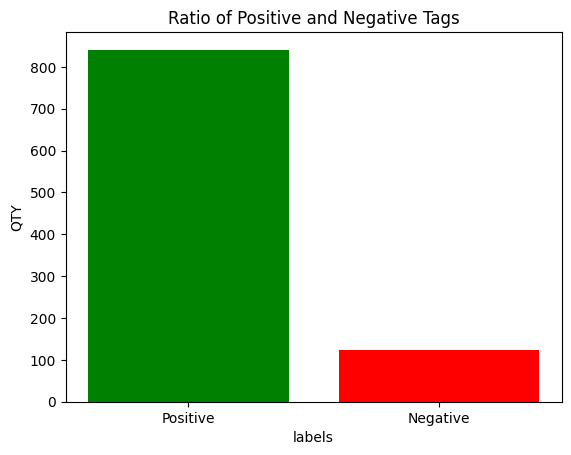

In [ ]:
# Plot the proportions
labels = ['Positive', 'Negative']
proportions = [proportion_positive, proportion_negative]

plt.bar(labels, label_count.tolist(), color=['green', 'red'])
plt.xlabel('labels')
plt.ylabel('QTY')
plt.title('Ratio of Positive and Negative Tags')
plt.show()

In [ ]:
ds_copy = ds.map()

Map:   0%|          | 0/964 [00:00<?, ? examples/s]

# **3- Data Split for Train and Val.**

In [ ]:
def split_dataset(ds):
    #Hacemos partición de entrenamiento, validación y prueba
    ds = ds.class_encode_column ('labels')

    train_test_valid = ds.train_test_split(test_size=0.3, seed=42, stratify_by_column='labels')

    # Particionamos validación y prueba en dos grupos (c/u con 50%)
    test_valid = train_test_valid['test'].train_test_split(test_size=0.1, seed = 42, stratify_by_column='labels')

    #Ahora hacemos un solo dataset con las tres particiones
    return DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

In [ ]:
ds_split = split_dataset(ds)
ds_split

Stringifying the column:   0%|          | 0/964 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/964 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 674
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 29
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 261
    })
})

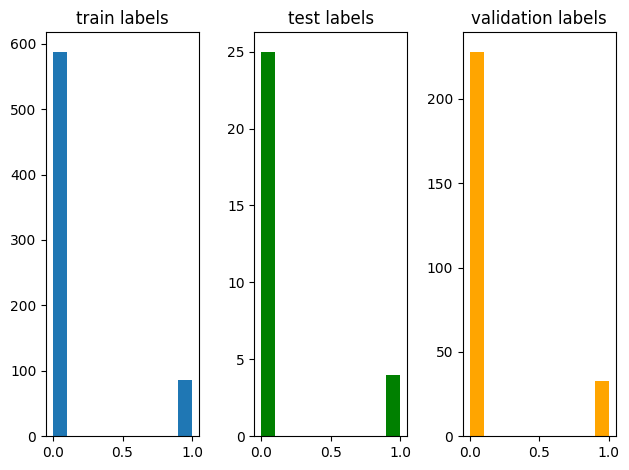

In [ ]:
from matplotlib import pyplot as plt
fig,(ax1, ax2, ax3) = plt.subplots(1,3)
ax1.set_title('train labels')
ax1.hist(ds_split['train']['labels'])
ax2.set_title('test labels')
ax2.hist(ds_split['test']['labels'],color='green')
ax3.set_title('validation labels')
ax3.hist(ds_split['valid']['labels'],color='orange')
fig.tight_layout()

# <font color='red'> **Data Augmentation**- No recommendable to run again

## **1- Creation of coype of data set to add the augmented Data.**

In [ ]:
ds_aug_split=ds_split.map()

Map:   0%|          | 0/674 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Map:   0%|          | 0/261 [00:00<?, ? examples/s]

In [ ]:
ds_aug_split

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 674
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 29
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 261
    })
})

## **2-Filter positive and Negative comments**.

In [ ]:
labels_1 = ds_aug_split['train'].to_pandas()[ds_aug_split['train'].to_pandas().labels== 1]
labels_0 = ds_aug_split['train'].to_pandas()[ds_aug_split['train'].to_pandas().labels== 0]

In [ ]:
labels_1

,text,labels
0,"Decent SUV, nice features, Jeep is usually alw...",1
6,I get about one phone call a month from a Jeep...,1
13,"On Wednesday November 23, 2011, I was pulling ...",1
20,I have great experience with my Jeep Compass. ...,1
39,So the lighting bolt light and esp light comes...,1
...,...,...
655,"Great vehicle, has had very few maintenance is...",1
656,The Jeep Cherokee Trailhawk rides surprisingly...,1
660,I love my Jeep Renegade but I wish it had more...,1
668,I’ve owned dozens of Jeeps since 1994. My 2018...,1


In [ ]:
labels_0

,text,labels
1,I have 2 Jeeps. One is a 2012 Jeep Patriot tha...,0
2,"Ok, I had an issue with my jeep stalling as I ...",0
3,I was so excited to buy a Jeep but turns out i...,0
4,My 2014 Jeep Cherokee was fine until July 1st ...,0
5,Battery died on me 4 times within 1 year. Thei...,0
...,...,...
667,"While driving my two young children, my 2010 J...",0
669,Purchased a 2014 Jeep Grand Cherokee and in le...,0
670,I recently purchased a used 2007 Jeep Commande...,0
671,My 2005 Jeep Grand Cherokee with a Hemi engine...,0


## **3-Text Generation**

In [ ]:
def gen_data(prompt,num):
  gen_comments=[]
  for comment in prompt:
    comments_generated = generator(
        comment,
        #max_length=500,
        do_sample=True,
        num_return_sequences = num,
        max_new_tokens=200,  # Qty Maximum of tokens to be added in the comment
        temperature=0.6)  #Latency to create text.
    gen_comments.extend(comments_generated)
  return gen_comments

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

generator=pipe = pipeline("text-generation", model="openai-community/gpt2")
# Define Comments:
positive_prompt =labels_1.text.tolist() # let's use all the positive comments 86
negative_prompt =labels_0.text.tolist()[0:20] # let's use only 20 comments

# Generar comentarios positivos y negativos
num_neg_comments = 1 # generate # comments per positive_prompt
num_pos_comments = 5 # generate # comment per negative_prompt
positive_comments = gen_data(positive_prompt,num_pos_comments)
negative_comments = gen_data(negative_prompt,num_neg_comments)



In [ ]:
positive_comments = [comment['generated_text'] for comment in positive_comments]
negative_comments = [comment['generated_text'] for comment in negative_comments]

In [ ]:
positive_labels=np.ones(len(positive_comments)).astype(int).tolist()
negative_labels=np.zeros(len(negative_comments)).astype(int).tolist()

In [ ]:
ds_pos=pd.DataFrame({"text":positive_comments,"labels":positive_labels})
ds_neg=pd.DataFrame({"text":negative_comments,"labels":negative_labels})

## **4- Creation of DataFrame and Storage in a file (Possitive and negative comments)**

In [ ]:
ds_gen = pd.concat([ds_pos, ds_neg])
ds_gen

,text,labels
0,"Decent SUV, nice features, Jeep is usually alw...",1
1,"Decent SUV, nice features, Jeep is usually alw...",1
2,"Decent SUV, nice features, Jeep is usually alw...",1
3,"Decent SUV, nice features, Jeep is usually alw...",1
4,"Decent SUV, nice features, Jeep is usually alw...",1
...,...,...
15,I own a 2005 Jeep Liberty which I bought brand...,0
16,Feb 2015 my 2014 Jeep Cherokee lost power whil...,0
17,I have a 2004 Jeep Liberty Limited which I pur...,0
18,I bought a 2014 Jeep Cherokee Trailhawk in Aug...,0


In [ ]:
ds_gen.to_csv('Jeep_synthetic_comments.csv', index=False,encoding = 'utf8')
files.download('Jeep_synthetic_comments.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Load Augmented Data from Github**

In [ ]:
ds_aug_split=ds_split.map()
url = 'https://raw.githubusercontent.com/JCLC9027/Proyecto_integrador_18/main/Jeep_synthetic_comments.csv'
ds_synthetic= pd.read_csv(url)
ds_synthetic

Map:   0%|          | 0/674 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Map:   0%|          | 0/261 [00:00<?, ? examples/s]

,text,labels
0,"Decent SUV, nice features, Jeep is usually alw...",1
1,"Decent SUV, nice features, Jeep is usually alw...",1
2,"Decent SUV, nice features, Jeep is usually alw...",1
3,"Decent SUV, nice features, Jeep is usually alw...",1
4,"Decent SUV, nice features, Jeep is usually alw...",1
...,...,...
445,I own a 2005 Jeep Liberty which I bought brand...,0
446,Feb 2015 my 2014 Jeep Cherokee lost power whil...,0
447,I have a 2004 Jeep Liberty Limited which I pur...,0
448,I bought a 2014 Jeep Cherokee Trailhawk in Aug...,0


In [ ]:
positive_comments = ds_synthetic [ds_synthetic.labels== 1]
negative_comments= ds_synthetic[ds_synthetic.labels== 0]

In [ ]:
positive_comments.head()

,text,labels
0,"Decent SUV, nice features, Jeep is usually alw...",1
1,"Decent SUV, nice features, Jeep is usually alw...",1
2,"Decent SUV, nice features, Jeep is usually alw...",1
3,"Decent SUV, nice features, Jeep is usually alw...",1
4,"Decent SUV, nice features, Jeep is usually alw...",1


In [ ]:
negative_comments.head()

,text,labels
430,I have 2 Jeeps. One is a 2012 Jeep Patriot tha...,0
431,"Ok, I had an issue with my jeep stalling as I ...",0
432,I was so excited to buy a Jeep but turns out i...,0
433,My 2014 Jeep Cherokee was fine until July 1st ...,0
434,Battery died on me 4 times within 1 year. Thei...,0


In [ ]:
for comment, label in zip(negative_comments.text, negative_comments.labels): ds_aug_split['train'] = ds_aug_split['train'].add_item({'text': comment, 'labels': label})
for comment, label in zip(positive_comments.text, positive_comments.labels): ds_aug_split['train'] = ds_aug_split['train'].add_item({'text': comment, 'labels': label})

In [ ]:
ds_aug_split

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 1124
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 29
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 261
    })
})

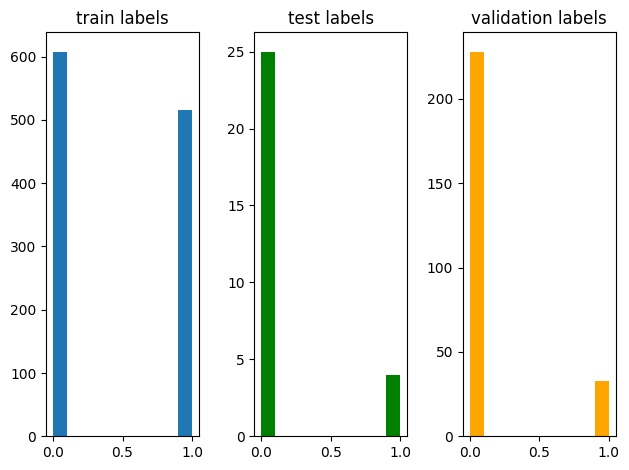

In [ ]:
from matplotlib import pyplot as plt
fig,(ax1, ax2, ax3) = plt.subplots(1,3)
ax1.set_title('train labels')
ax1.hist(ds_aug_split['train']['labels'])
ax2.set_title('test labels')
ax2.hist(ds_aug_split['test']['labels'],color='green')
ax3.set_title('validation labels')
ax3.hist(ds_aug_split['valid']['labels'],color='orange')
fig.tight_layout()

#**Sentiment Analysis using -Transformer "distilbert-base-cased"**

Train with PyTorch Trainer

## **1- Load transformer model tokenizer and tokenize the data sets.**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = ds_split.map(tokenize_function, batched=True)

Map:   0%|          | 0/674 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Map:   0%|          | 0/261 [00:00<?, ? examples/s]

In [ ]:
train_dataset = tokenized_datasets["train"].shuffle(seed=42)
valid_dataset = tokenized_datasets["valid"].shuffle(seed=42)
test_dataset = tokenized_datasets["test"].shuffle(seed=42)

##**2-Verify and define the device to work**

In [ ]:
def get_device():
    if torch.backends.mps.is_available():
        return torch.device('mps')
    elif torch.cuda.is_available():
        return torch.device(torch.cuda.current_device())
    else:
        return torch.device('cpu')

In [ ]:
get_device()

device(type='cuda', index=0)

**3- Load Transformer model for clasification**

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model.to(get_device())

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

##**4- Define the compute metric**

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

##**5-Define the training arguments and Trainer**

In [ ]:
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

## **6-Train the Model and Evaluate the model**

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.196612,0.946360
2,No log,0.219985,0.938697
3,No log,0.207147,0.950192


TrainOutput(global_step=255, training_loss=0.18696320477653952, metrics={'train_runtime': 110.4687, 'train_samples_per_second': 18.304, 'train_steps_per_second': 2.308, 'total_flos': 267849080082432.0, 'train_loss': 0.18696320477653952, 'epoch': 3.0})

In [ ]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.006478124763816595,
 'eval_accuracy': 1.0,
 'eval_runtime': 0.5366,
 'eval_samples_per_second': 54.044,
 'eval_steps_per_second': 7.454,
 'epoch': 3.0}

## **7-Visual review of the Data predictions**

In [ ]:
predictions = trainer.predict(test_dataset)
final_preds = [{ 'text': test_dataset['text'][i], 'pred': pred, 'label': test_dataset['labels'][i] } for i,pred in enumerate(predictions.predictions.argmax(-1))]

In [ ]:
df_pred_tuned = pd.DataFrame(final_preds)
df_pred_tuned

,text,pred,label
0,The water pump on my 2009 Jeep Liberty went ba...,0,0
1,I have purchased a brand new 2016 Jeep Latitud...,0,0
2,Jeep Compass is good on gas. I am glad I picke...,1,1
3,I love my Jeep Sport Wrangler. Owning a Jeep i...,1,1
4,I purchased a 2022 Jeep Grand Cherokee Limited...,0,0
5,It's a very good looking car. Great color that...,1,1
6,"I am 65 years old, and purchased a 2007 Jeep L...",0,0
7,"The Jeep is sturdy, strong, reliable and handl...",1,1
8,I bought a Jeep Cherokee Trailhawk used in 202...,0,0
9,Just wanted to warn Jeep owners or possible Je...,0,0


## **8-Confusion Matrix Evaluation**

Matriz de confusión - finetuning-sentiment-model-amazonbaby-5000samples-MNA-NLP-EQ5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00         4

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



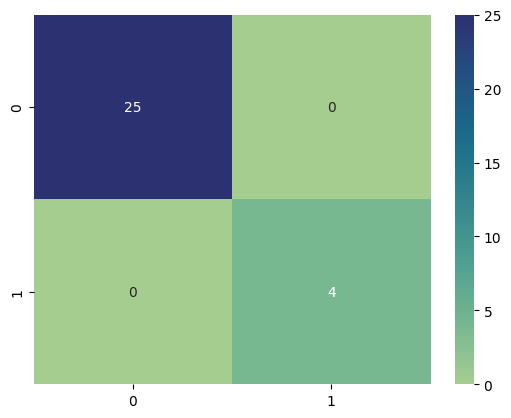

In [ ]:
cm_tuned = confusion_matrix(df_pred_tuned['label'],df_pred_tuned['pred'])
sns.heatmap(cm_tuned, annot=True, fmt = "d",cmap="crest")
print("Matriz de confusión - finetuning-sentiment-model-amazonbaby-5000samples-MNA-NLP-EQ5")
print(classification_report(df_pred_tuned['label'],df_pred_tuned['pred']))

#**Sentiment Analysis using -Transformer "distilbert-base-cased"**  <font color='Blue'> with Data Augmented
Train with PyTorch Trainer

## **1- Load transformer model tokenizer and tokenize the data sets.**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = ds_aug_split.map(tokenize_function, batched=True)

Map:   0%|          | 0/1124 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Map:   0%|          | 0/261 [00:00<?, ? examples/s]

In [ ]:
train_dataset = tokenized_datasets["train"].shuffle(seed=42)
valid_dataset = tokenized_datasets["valid"].shuffle(seed=42)
test_dataset = tokenized_datasets["test"].shuffle(seed=42)

##**2-Verify and define the device to work**

In [ ]:
def get_device():
    if torch.backends.mps.is_available():
        return torch.device('mps')
    elif torch.cuda.is_available():
        return torch.device(torch.cuda.current_device())
    else:
        return torch.device('cpu')

In [ ]:
get_device()

device(type='cuda', index=0)

**3- Load Transformer model for clasification**

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model.to(get_device())

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

##**4- Define the compute metric**

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

##**5-Define the training arguments and Trainer**

In [ ]:
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

## **6-Train the Model and Evaluate the model**

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.238744,0.957854
2,No log,0.307813,0.942529
3,No log,0.298031,0.946360


TrainOutput(global_step=423, training_loss=0.11884492734363457, metrics={'train_runtime': 179.2871, 'train_samples_per_second': 18.808, 'train_steps_per_second': 2.359, 'total_flos': 446680068268032.0, 'train_loss': 0.11884492734363457, 'epoch': 3.0})

In [ ]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.000944967323448509,
 'eval_accuracy': 1.0,
 'eval_runtime': 0.5169,
 'eval_samples_per_second': 56.105,
 'eval_steps_per_second': 7.739,
 'epoch': 3.0}

## **7-Visual review of the Data predictions**

In [ ]:
predictions = trainer.predict(test_dataset)
final_preds = [{ 'text': test_dataset['text'][i], 'pred': pred, 'label': test_dataset['labels'][i] } for i,pred in enumerate(predictions.predictions.argmax(-1))]

In [ ]:
df_pred_tuned = pd.DataFrame(final_preds)
df_pred_tuned

,text,pred,label
0,The water pump on my 2009 Jeep Liberty went ba...,0,0
1,I have purchased a brand new 2016 Jeep Latitud...,0,0
2,Jeep Compass is good on gas. I am glad I picke...,1,1
3,I love my Jeep Sport Wrangler. Owning a Jeep i...,1,1
4,I purchased a 2022 Jeep Grand Cherokee Limited...,0,0
5,It's a very good looking car. Great color that...,1,1
6,"I am 65 years old, and purchased a 2007 Jeep L...",0,0
7,"The Jeep is sturdy, strong, reliable and handl...",1,1
8,I bought a Jeep Cherokee Trailhawk used in 202...,0,0
9,Just wanted to warn Jeep owners or possible Je...,0,0


## **8-Confusion Matrix Evaluation**

Matriz de confusión- finetuning-sentiment-with data augmentation-jeep-customer-review
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00         4

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



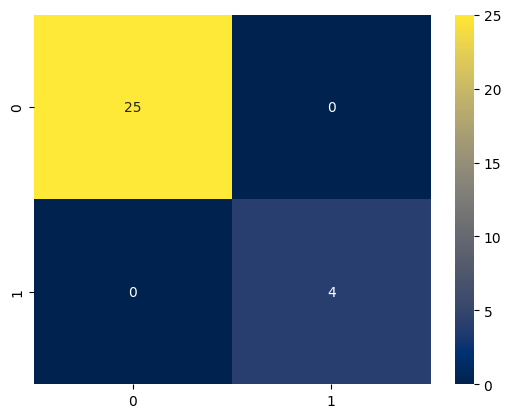

In [ ]:
cm_tuned = confusion_matrix(df_pred_tuned['label'],df_pred_tuned['pred'])
sns.heatmap(cm_tuned, annot=True, fmt = "d",cmap="cividis")
print("Matriz de confusión- finetuning-sentiment-with data augmentation-jeep-customer-review")
print(classification_report(df_pred_tuned['label'],df_pred_tuned['pred']))

# <font color='Green'>**Using NLP Tools**

## **Libraries to install for embbedings**


In [ ]:
# Just run this if you have not download the Fasttext embbedbings Model.
!pip install fasttext # just run once and then return it as a comment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199770 sha256=c0eb2663e21d8adac9b7146698d6a840431184a8b7e88dc09c79db4ee34e006f
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
import fasttext
import fasttext.util

## **Load Data in to List.**


In [ ]:
X=ds.to_pandas().text.tolist()
Y=ds.to_pandas().labels.tolist()

## **Text Preprocessing**

Stop words Elimination, Clean, Tokenization and lematization.

### Download the library of NLTK (Natural Language Toolkit) for data processing.

In [ ]:
nltk.download('punkt')    # It is a tokenizer that helps split text into statements using an unsupervised model.
nltk.download('stopwords')    # to access stopwords in multiple languages.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Let's see the list of stopwords that are included by default in the NLTK library suite:

print(len(stopwords.words('english')))
print(stopwords.words('english'))

# Let's consider the following list of words associated with negations in English:

negwords = [ 'no', 'nor', 'not', 'ain', 'aren', "aren't", 'don', "don't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]


179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than

In [ ]:
#Exclude all words in the "negwords" list from the default "stopwords" list, to define a new set called mystopwords

mystopwords = list(set(stopwords.words('english')) - set(negwords))

print(len(mystopwords))
print(mystopwords)


139
['but', 'himself', 'them', "she's", "should've", 'all', 'o', 'such', 'ourselves', "you've", 'whom', 'now', 'itself', 'did', 'should', 'we', 'as', 'here', 'why', 'they', 'some', 'only', "it's", 'by', 'been', 'until', 'with', 'under', 'further', 'are', 'am', 'after', 'most', 'from', 'of', 're', 'on', 'before', 's', "you'll", 'over', 'a', 'be', 'the', 'each', 'during', 'have', 'out', 'against', 'same', 'themselves', 'our', 'had', 'ma', "you're", 'their', 'for', 'what', 'her', 'so', 'because', 'can', 'an', 'there', 'any', 'he', 'herself', 'at', 'if', 'me', 'has', 'yours', 'your', 'is', 'own', "you'd", 'where', 'up', 'yourselves', 'and', 'how', 'or', 'in', 'who', 'yourself', 't', 'will', 'do', "that'll", 'him', 'than', 'these', 'very', 'again', 'does', 'more', 'into', 'd', 'you', 'she', 'ours', 'my', 'about', 'm', 'his', 've', 'through', 'those', 'theirs', 'just', 'were', 'both', 'i', 'between', 'its', 'below', 'once', 'hers', 'off', 'too', 'll', 'other', 'down', 'while', 'y', 'few', 't

## **Clean and tokenization:**

Justification of the cleaning process:

In the next block we define the function that will clean the text and return the tokens of each comment. The following steps were performed for the cleaning process:

1- Remove special characters: Punctuation marks and special characters do not add value to the type of analysis we want to perform. Therefore, not removing them could affect the performance of our model. For this reason it was decided to remove these characters.

2-Convert all letters to lowercase: This is done to prevent the model from identifying the same words as different but one written in lowercase and another in uppercase.

3-Stemming: This option was selected since when testing the model with both Stemming and Lemmatization, the latter tends to overtrain the model. In terms of accuracy, both have similar behavior for the data set we are working with.

In [ ]:
# Clean and Tokenization:

def clean_tok(doc):
    ps=PorterStemmer()
    # With REGEX we replace with space everything that is not a letter or space, leaving only alphabetic characters
    doc = re.sub(r'[^A-Za-z\s]', ' ', doc)
    # With REGEX we replace all double or greater spaces with single spaces
    doc = re.sub(r'\s{2,}', ' ', doc)
    # We simplify everything to lowercase
    doc = doc.lower()
    # We apply tokenization
    doc = nltk.word_tokenize(doc)
    # We filter the stopwords, we consider only tokens greater than 1
    return [ps.stem(word) for word in doc if word not in mystopwords and len(word) > 1]

In [ ]:
Xclean = np.array([clean_tok(x) for x in X], dtype=object)  #Comments processed

#Delete empty comments
filter_Xclean = [False if com == [] else True for com in Xclean]
Xclean = Xclean[filter_Xclean]

#Remove the Y's from these comments to maintain the size of the data set
Y = np.array(Y, dtype=object)
Y = Y[filter_Xclean]

for x in Xclean[5:10]:
  print(x)
Y[5:10] # labels

['name', 'deborah', 'purchas', 'compass', 'februari', 'mile', 'total', 'fell', 'love', 'vehicl', 'ran', 'like', 'dream', 'new', 'vehicl', 'mile', 'engin', 'start', 'run', 'rough', 'transmiss', 'start', 'shift', 'hard', 'took', 'dealership', 'per', 'recommend', 'jeep', 'custom', 'servic', 'open', 'case', 'said', 'check', 'certifi', 'chrysler', 'technician', 'check', 'softwar', 'updat', 'fix', 'shift', 'problem', 'gear', 'ask', 'owner', 'not', 'notifi', 'softwar', 'updat', 'told', 'way', 'find', 'softwar', 'updat', 'take', 'dealership', 'someth', 'els', 'return', 'jeep', 'transmiss', 'shift', 'becam', 'wors', 'return', 'dealership', 'day', 'technician', 'rode', 'felt', 'issu', 'discuss', 'week', 'jeep', 'dealership', 'multipl', 'technician', 'drove', 'felt', 'issu', 'transmiss', 'receiv', 'written', 'statement', 'pick', 'jeep', 'exact', 'issu', 'dealership', 'return', 'state', 'noth', 'wrong', 'show', 'no', 'code', 'jeep', 'custom', 'servic', 'close', 'case', 'within', 'week', 'transmiss

array([0, 0, 0, 0, 0], dtype=object)

**Note:** Rationale for the additional cleaning process:

Now we proceed to generate the clean comments. As a result of the cleaning, some lines remain empty so they are eliminated. Leaving these lines empty affects the performance of the model, since it considers them as part of the vocabulary during the analysis.

## **Word Cloud Analysis**

Word cloud analysis is a technique used to visualize the frequency of words within a given text corpus. It generates a visual representation where the size of each word corresponds to its frequency in the text.



In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

pos_tok=[]  # initialize lists of positive and negative tokens
neg_tok=[]

for x,c in zip(Xclean, Y):
  if c==1:
    pos_tok.extend(x)   # tokens used in positive comments
  else:
    neg_tok.extend(x)   # tokens used in negative comments

pt = ' '.join(pos_tok)  # we require a single string for each class for the word cloud.
nt = ' '.join(neg_tok)

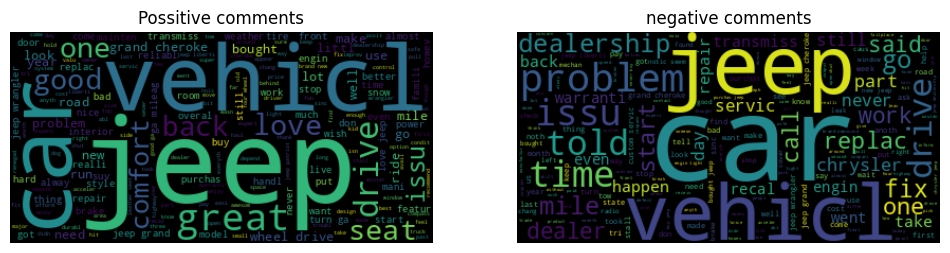

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))

# Positive feedback word cloud:
wordcloudnn = WordCloud().generate(pt)
ax1.imshow(wordcloudnn, interpolation='bilinear')
ax1.axis("off")
ax1.set_title('Possitive comments')

# Negative comments word cloud:
wordcloudnn = WordCloud().generate(nt)
ax2.imshow(wordcloudnn, interpolation='bilinear')
ax2.axis("off")
ax2.set_title('negative comments')

plt.show()

## **Data Split for Train, Validation and Test**

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val_and_test, y_train, y_val_and_test = train_test_split(Xclean, Y, train_size=.70, shuffle=True, random_state=1,stratify=Y)
x_val, x_test, y_val, y_test = train_test_split(x_val_and_test, y_val_and_test, test_size=.5, shuffle=True, random_state=1, stratify=y_val_and_test)

print('X,y Train:', len(x_train), len(y_train))      # los "x_" son "list" y los "y_" son "Series"
print('X,y Val:', len(x_val), len(y_val))
print('X,y Test', len(x_test), len(y_test))

X,y Train: 674 674
X,y Val: 145 145
X,y Test 145 145


**Code to plot validation sets**

In [ ]:
from collections import Counter
train_label_count = Counter(y_train)
test_label_count = Counter(y_test)
val_label_count = Counter(y_val)

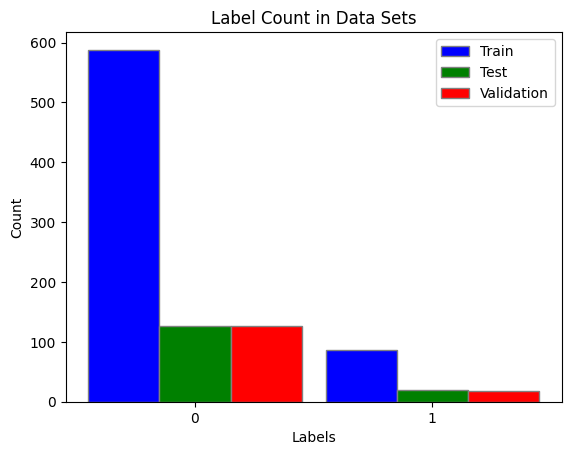

In [ ]:
# Convert counts into lists of values
labels = list(train_label_count.keys())
train_counts = list(train_label_count.values())
test_counts = list(test_label_count.values())
val_counts = list(val_label_count.values())

# Define the width of the bars
bar_width = 0.3

# Adjust the position of the bars
r1 = range(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar plot
plt.bar(r1, train_counts, color='blue', width=bar_width, edgecolor='grey', label='Train')
plt.bar(r2, test_counts, color='green', width=bar_width, edgecolor='grey', label='Test')
plt.bar(r3, val_counts, color='red', width=bar_width, edgecolor='grey', label='Validation')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Count in Data Sets')
plt.xticks([r + bar_width for r in range(len(labels))], labels)
plt.legend()

# Show the plot
plt.show()

## **Vocabulary creation and Filtration:**

In this step let's create a first vocabulary using only the training data. This data is used to avoid information leakage (data leak).

### **Vocabulary creation**

In [ ]:
#We create a first vocabulary, which will not be cut so as not to lose information

from collections import Counter

vocab = Counter() #Vocabulario

for k in range(len(x_train)):
 vocab.update(x_train[k])

print('Training dictionary length:', len(vocab))
print('\n(word,frequency):')
print(vocab.most_common(100))


Training dictionary length: 4309

(word,frequency):
[('jeep', 2058), ('not', 1203), ('car', 927), ('vehicl', 736), ('problem', 573), ('time', 567), ('would', 521), ('drive', 507), ('no', 502), ('get', 496), ('back', 485), ('dealership', 471), ('issu', 437), ('servic', 413), ('chrysler', 411), ('mile', 379), ('call', 379), ('new', 373), ('go', 370), ('told', 360), ('fix', 356), ('dealer', 353), ('replac', 345), ('start', 337), ('one', 323), ('work', 305), ('day', 302), ('year', 298), ('said', 295), ('engin', 295), ('like', 286), ('warranti', 282), ('cheroke', 274), ('light', 266), ('purchas', 264), ('month', 261), ('never', 257), ('transmiss', 252), ('took', 251), ('bought', 251), ('could', 242), ('part', 241), ('need', 231), ('take', 229), ('still', 229), ('even', 211), ('custom', 211), ('happen', 207), ('week', 207), ('repair', 202), ('buy', 198), ('come', 195), ('anoth', 192), ('went', 189), ('recal', 186), ('got', 186), ('also', 185), ('don', 177), ('grand', 177), ('stop', 174), ('w

**Note:** This additional step is to eliminate words with a frecuency 1 to avoid creating sparse matrices, since as the dictionary grows so will the matrices. The above would cause the model to be overtrained.

In [ ]:
#Considers a minimum frequency appropriate for the project

min_freq = 2

midicc = {k: v for k, v in vocab.items() if v >= min_freq}

print('New length of new vocabulary:', len(midicc))
print(list(midicc.items())[0:5]) # let's look at some dictionary items.

New length of new vocabulary: 2691
[('jeep', 2058), ('liberti', 119), ('sport', 29), ('drive', 507), ('listen', 6)]


### **Filtration**

Let's filter the Train, Validation and Test sets with respect to the new proposed vocabulary

In [ ]:
#Function to filter new vocabulary

def filter_out_empty_comments(doc: list, y: list) -> tuple:
    filter_list = [False if line == [] else True for line in doc]
    filtered_doc = np.array(doc, dtype=object)[filter_list]
    filtered_y = np.array(y, dtype = int)[filter_list]

    return (filtered_doc, filtered_y)

In [ ]:
train_x = []
for ss in x_train:
  train_x.append([w for w in ss if w in midicc])

val_x = []
for ss in x_val:
  val_x.append([w for w in ss if w in midicc])

test_x = []
for ss in x_test:
  test_x.append([w for w in ss if w in midicc])

train_x, y_train = filter_out_empty_comments(train_x, y_train)
val_x, y_val = filter_out_empty_comments(val_x, y_val)
test_x, y_test = filter_out_empty_comments(test_x, y_test)

#Review output
for k in range(3):
  print('before:', x_train[k])
  print('after:', train_x[k])

before: ['jeep', 'liberti', 'sport', 'drive', 'listen', 'stereo', 'drown', 'wind', 'nois', 'sky', 'slider', 'roof', 'pop', 'slam', 'open', 'someth', 'flew', 'sound', 'like', 'brace', 'bar', 'dark', 'thank', 'no', 'one', 'behind', 'took', 'brandon', 'chrysler', 'dodg', 'jeep', 'unfortun', 'don', 'seem', 'abl', 'fix', 'anyth', 'without', 'screw', 'thing', 'improperli', 'instal', 'slider', 'top', 'greas', 'water', 'stain', 'match', 'carpet', 'botch', 'first', 'attempt', 'fix', 'fact', 'top', 'would', 'not', 'close', 'complet', 'funni', 'not', 'seem', 'find', 'problem', 'major', 'issu', 'happen', 'love', 'jeep', 'slider', 'top', 'noisi', 'unpredict', 'danger']
after: ['jeep', 'liberti', 'sport', 'drive', 'listen', 'stereo', 'wind', 'nois', 'sky', 'slider', 'roof', 'pop', 'slam', 'open', 'someth', 'flew', 'sound', 'like', 'brace', 'bar', 'dark', 'thank', 'no', 'one', 'behind', 'took', 'chrysler', 'dodg', 'jeep', 'unfortun', 'don', 'seem', 'abl', 'fix', 'anyth', 'without', 'screw', 'thing', 

## **Text Encoding or Text representation**

Text representation in NLP involves transforming raw text data into a format that machine learning models can understand and process effectively.

For this project we will compare 3 Techniques:

- Cont Vectorizer.
- TF-IDF (Term Frequency-Inverse Document Frequency).
- Word Embeddings -> Embedded FastText vectors pre-trained by Facebook.

## **Count vectorizer**
The count vectorizer is a way to represent text in natural language processing that converts a collection of documents into a document-word matrix. Encoding is therefore done at the document level, rather than at the token level.

Being a bag-of-words model, information regarding the position of the tokens or their context is not encoded, only information about whether they appear and their frequency.

In [ ]:
# Let's get the counting arrays
train_x_docs = []
for k in range(len(train_x)):
  train_x_docs.append(' '.join(train_x[k]))

val_x_docs = []
for k in range(len(val_x)):
  val_x_docs.append(' '.join(val_x[k]))

test_x_docs = []
for k in range(len(test_x)):
  test_x_docs.append(' '.join(test_x[k]))


# let's verify that the first Train comments are each as a single string:
for k in range(3):
  print(train_x_docs[k])


jeep liberti sport drive listen stereo wind nois sky slider roof pop slam open someth flew sound like brace bar dark thank no one behind took chrysler dodg jeep unfortun don seem abl fix anyth without screw thing instal slider top greas water stain match carpet first attempt fix fact top would not close complet funni not seem find problem major issu happen love jeep slider top noisi danger
bought compass new lot didn live standard cheroke fine drive year start troubl cvt terribl whine nois warn light come transmiss fluid overh stop jeep let cool fine next time took dealer couldn find anyth wrong recommend chang fluid done day ago paid thought ok today way home work mile highway drive everi warn light dash began flash alarm sound pull shut minut start no light come except radio clock won move park power window work power lock won tow mile dealer don know electr comput issu transmiss begin hate vehicl doesn deserv jeep name anyon els issu
vehicl merced speed manual transmiss would assum 

In [ ]:
#let make the dicc to a list
mivocab = list(midicc.keys())

In [ ]:
# let's generate the required sparse matrices based on the token count:
from sklearn.feature_extraction.text import CountVectorizer

countvectorizer = CountVectorizer(vocabulary=mivocab)
train_x_count = countvectorizer.fit_transform(train_x_docs)
val_x_count = countvectorizer.transform(val_x_docs)
test_x_count = countvectorizer.transform(test_x_docs)

count_tokens = countvectorizer.get_feature_names_out()
df_countvect = pd.DataFrame(data = train_x_count.toarray(),  columns = count_tokens)
print(df_countvect.iloc[0:3,6:18])

   wind  nois  sky  slider  roof  pop  slam  open  someth  flew  sound  like
0     1     1    1       3     1    1     1     1       1     1      1     1
1     0     1    0       0     0    0     0     0       0     0      1     0
2     0     0    0       0     0    0     0     0       0     0      0     0


In [ ]:
p_sparse = 1 - train_x_count.count_nonzero() / (train_x_count.shape[0] * train_x_count.shape[1])    # Sparsity : % of values in 0.
print('Percent of zero values of the training sparse matrix: %.1f%%' % (100*p_sparse))

Percent of zero values of the training sparse matrix: 97.6%


## **2-TF-IDF Score Vectorizer**

In populating the Document-Term Matrix with the number of occurrences, frequently occurring terms are assigned a higher score than the rarely occurring terms.

TF-IDF score is a combination of two metrics: the Term Frequency (TF) and the Inverse Document Frequency (IDF).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid = TfidfVectorizer(vocabulary=mivocab)

#Entrenamiento del modelo en train
train_x_tfidf = tfid.fit_transform(train_x_docs)
val_x_tfidf = tfid.transform(val_x_docs)

#Resultados del entrenamiento
tfidf_tokens = tfid.get_feature_names_out()
df_tfidfvect = pd.DataFrame(data = train_x_tfidf.toarray(),  columns = tfidf_tokens)
print(df_tfidfvect.iloc[0:3,6:18])

#Realizamos el entrenamiento en test
test_x_tfidf = tfid.transform(test_x_docs)


       wind      nois      sky    slider      roof      pop      slam  \
0  0.141379  0.092773  0.14451  0.433531  0.121512  0.12447  0.127797   
1  0.000000  0.090763  0.00000  0.000000  0.000000  0.00000  0.000000   
2  0.000000  0.000000  0.00000  0.000000  0.000000  0.00000  0.000000   

       open    someth      flew     sound      like  
0  0.095787  0.086092  0.157007  0.101719  0.060292  
1  0.000000  0.000000  0.000000  0.099515  0.000000  
2  0.000000  0.000000  0.000000  0.000000  0.000000  


## **3-Embedded FastText vectors pre-trained by Facebook.**
FastText is a Gensim model used to perform word embedding and classification. In it, supervised and unsupervised learning algorithms are created that are used to obtain vector representations of words.

In [ ]:
ft = fasttext.load_model('/content/drive/MyDrive/14-proyecto/cc.en.300.bin')

In [ ]:
fast_text_voca = {}

for w in range(len(mivocab)):
  fast_text_voca[mivocab[w]] = ft.get_word_vector(mivocab[w]) # Variable where the vocabulary generated by FastText is stored.
## Save dictionary to an npy file.
np.save('fast_text_voca.npy', fast_text_voca)

In [ ]:
# Remove comments if you want to load the dictionary created with the 300 embedded vectors.

import numpy as np
##Reading the npy file.
#fast_text_voca = np.load('fast_text_voca.npy', allow_pickle='TRUE')
#fast_text_voca=fast_text_voca.item()  # Se convierte la variable de numpy array a diccionario.
print("Number of tokens:",len(fast_text_voca))
print("Number of pre-trained embedded vectors of the word 'much':",len(fast_text_voca.get('much')))

In [ ]:
trainEmb = []
for ss in train_x:
  embeddings=[]
  for w in ss:
    embeddings.append(fast_text_voca[w])
  trainEmb.append(np.mean(embeddings, axis=0)) #calculate the average of each comment
trainEmb=np.array(trainEmb)# convert to matrix

valEmb = []
for ss in val_x:
  embeddings=[]
  for w in ss:
    embeddings.append(fast_text_voca[w])
  valEmb.append(np.mean(embeddings, axis=0)) #calculate the average of each comment
valEmb=np.array(valEmb)# convert to matrix

testEmb = []
for ss in test_x:
  embeddings=[]
  for w in ss:
    embeddings.append(fast_text_voca[w])
  testEmb.append(np.mean(embeddings, axis=0)) #calculate the average of each comment
testEmb=np.array(testEmb)# convert to matrix


print("Training set dimensions:",trainEmb.shape)
print("Validation set dimensions:",valEmb.shape)
print("Test set dimensions",testEmb.shape)


## **Machine Learning Models**

Logistic Regression and Random Forest will be used to evaluate the 3 text encoding conditions:

In [ ]:
# Machine learning models with Count Vectorizer
LR_model_count=LogisticRegression(C=0.05, penalty='l2', solver= 'liblinear',max_iter=400,class_weight= 'balanced' )
LR_model_count.fit(train_x_count,y_train)
RF_model_count = RandomForestClassifier(criterion='gini',max_depth=10,min_samples_split=50,min_samples_leaf=3,max_features='log2',n_jobs=-1,max_samples=0.0666,random_state=10,class_weight= 'balanced' )
RF_model_count.fit(train_x_count,y_train)

# Machine learning models with TF-IDF Score Vectorizer:
LR_model_tfidf=LogisticRegression(C=0.05, penalty='l2', solver= 'liblinear',max_iter=10,class_weight= 'balanced' )
LR_model_tfidf.fit(train_x_tfidf,y_train)
RF_model_tfidf = RandomForestClassifier(criterion='gini',max_depth=10,min_samples_split=50,min_samples_leaf=3,max_features='log2',n_jobs=-1,max_samples=0.0666,random_state=10,class_weight= 'balanced')
RF_model_tfidf.fit(train_x_tfidf,y_train)

# #Machine learning model with fastText" embedded vectors
# LR_model_emb = LogisticRegression(C=0.05, penalty='l2', solver= 'liblinear',max_iter=400,class_weight= 'balanced' )
# LR_model_emb.fit(trainEmb,y_train)
# RF_model_emb= RandomForestClassifier(criterion='gini',max_depth=1,min_samples_split=10,min_samples_leaf=1,max_features='log2',n_jobs=-1,max_samples=191,random_state=10,class_weight= 'balanced' )
# RF_model_emb.fit(trainEmb,y_train)

#REsults with Count Vectorizer
print('Results using "Count Vectorizer"')
print('Results Logistic Regression:')
print('LR_count: Train-accuracy: %.2f%%' % (100*LR_model_count.score(train_x_count, y_train)))
print('LR_count: Val-accuracy: %2.f%%' % (100*LR_model_count.score(val_x_count, y_val)))
print('Results Random Forest:')
print('RF_count: Train-accuracy: %.2f%%' % (100*RF_model_count.score(train_x_count, y_train)))
print('RF_count: Val-accuracy: %.2f%%' % (100*RF_model_count.score(val_x_count, y_val)))

print('\nResults using "TF-IDF Score Vectorizer"')
print('Results Logistic Regression:')
print('LR_tfidf: Train-accuracy: %.2f%%' % (100*LR_model_tfidf.score(train_x_tfidf, y_train)))
print('LR_tfidf: Val-accuracy: %2.f%%' % (100*LR_model_tfidf.score(val_x_tfidf, y_val)))
print('Results Random Forest:')
print('RF_tfidf: Train-accuracy: %.2f%%' % (100*RF_model_tfidf.score(train_x_tfidf, y_train)))
print('RF_tfidf: Val-accuracy: %.2f%%' % (100*RF_model_tfidf.score(val_x_tfidf, y_val)))

# #REsults with fastText" embedded vectors
# print('\nResults using "fastText" embedded vectors')
# print('Results Logistic Regression:')
# print('LR_emb: Train-accuracy: %.2f%%' % (100*LR_model_emb.score(trainEmb, y_train)))
# print('LR_emb: Val-accuracy: %2.f%%' % (100*LR_model_emb.score(valEmb, y_val)))
# print('Results Random Forest:')
# print('RF_emb: Train-accuracy: %.2f%%' % (100*RF_model_emb.score(trainEmb, y_train)))
# print('RF_emb: Val-accuracy: %.2f%%' % (100*RF_model_emb.score(valEmb, y_val)))

Results using "Count Vectorizer"
Results Logistic Regression:
LR_count: Train-accuracy: 97.92%
LR_count: Val-accuracy: 91%
Results Random Forest:
RF_count: Train-accuracy: 87.24%
RF_count: Val-accuracy: 87.59%

Results using "TF-IDF Score Vectorizer"
Results Logistic Regression:
LR_tfidf: Train-accuracy: 96.74%
LR_tfidf: Val-accuracy: 95%
Results Random Forest:
RF_tfidf: Train-accuracy: 87.24%
RF_tfidf: Val-accuracy: 87.59%


## **Machine learning models evaluation**


### **Results using Count Vectorizer**


Confusion matrix for Logistic Regression (RL) Count Vectorizer
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       126
           1       0.90      0.47      0.62        19

    accuracy                           0.92       145
   macro avg       0.91      0.73      0.79       145
weighted avg       0.92      0.92      0.91       145



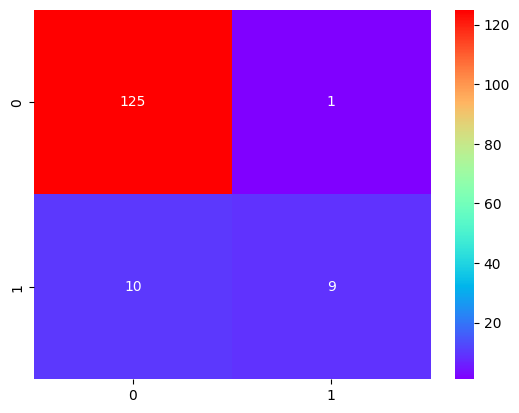

In [ ]:
y_pred_LR = LR_model_tfidf.predict(test_x_count)
cm_LR = confusion_matrix(y_test,y_pred_LR)
sns.heatmap(cm_LR, annot=True, fmt = "d",cmap="rainbow")
print("Confusion matrix for Logistic Regression (RL) Count Vectorizer")
print(classification_report(y_test,y_pred_LR))

Confusion matrix for Random Forest (RF) using fastText embedded vectors
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       126
           1       0.00      0.00      0.00        19

    accuracy                           0.87       145
   macro avg       0.43      0.50      0.46       145
weighted avg       0.76      0.87      0.81       145



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


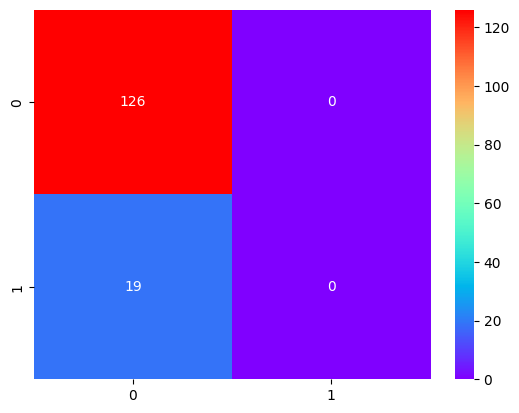

In [ ]:

y_pred_RF = RF_model_tfidf.predict(test_x_count)
cm_RF = confusion_matrix(y_test,y_pred_RF)
sns.heatmap(cm_RF, annot=True, fmt = "d",cmap="rainbow")
print("Confusion matrix for Random Forest (RF) using fastText embedded vectors")
print(classification_report(y_test,y_pred_RF))


### **Results using TF-IDF Score Vectorizer**


Confusion matrix for Logistic Regression (RL) TF-IDF Score Vectorizer
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       126
           1       0.92      0.63      0.75        19

    accuracy                           0.94       145
   macro avg       0.94      0.81      0.86       145
weighted avg       0.94      0.94      0.94       145



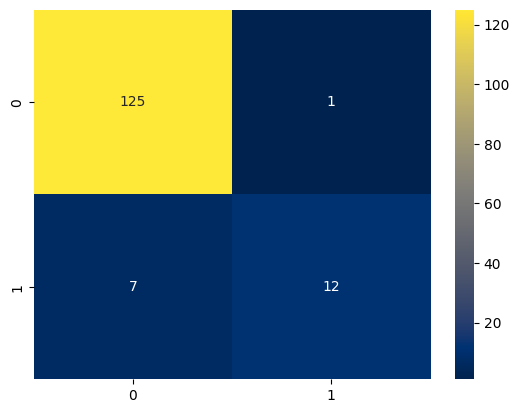

In [ ]:
y_pred_LR = LR_model_tfidf.predict(test_x_tfidf)
cm_LR = confusion_matrix(y_test,y_pred_LR)
sns.heatmap(cm_LR, annot=True, fmt = "d",cmap="cividis")
print("Confusion matrix for Logistic Regression (RL) TF-IDF Score Vectorizer")
print(classification_report(y_test,y_pred_LR))

Confusion matrix for Random Forest (RF) using fastText embedded vectors
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       126
           1       0.00      0.00      0.00        19

    accuracy                           0.87       145
   macro avg       0.43      0.50      0.46       145
weighted avg       0.76      0.87      0.81       145



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


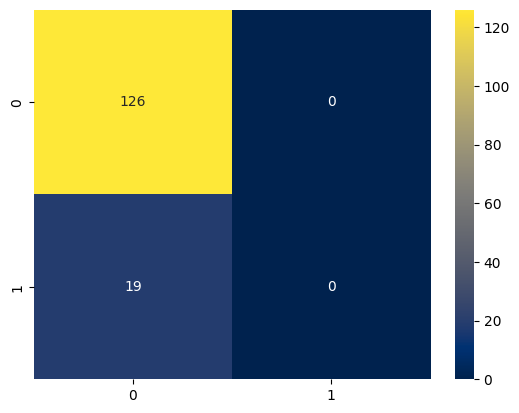

In [ ]:

y_pred_RF = RF_model_tfidf.predict(test_x_tfidf)
cm_RF = confusion_matrix(y_test,y_pred_RF)
sns.heatmap(cm_RF, annot=True, fmt = "d",cmap="cividis")
print("Confusion matrix for Random Forest (RF) using fastText embedded vectors")
print(classification_report(y_test,y_pred_RF))


### **Results using FastText Embeddbings**


Confusion matrix for Logistic Regression (RL) using fastText embedded vectors
              precision    recall  f1-score   support

           0       0.70      0.95      0.81        22
           1       0.91      0.53      0.67        19

    accuracy                           0.76        41
   macro avg       0.80      0.74      0.74        41
weighted avg       0.80      0.76      0.74        41



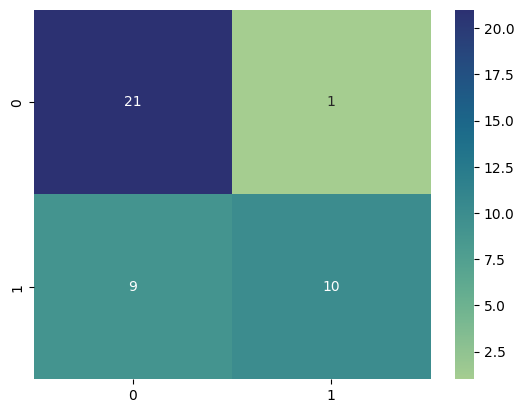

In [ ]:
y_pred_LR = LR_model_emb.predict(testEmb)
cm_LR = confusion_matrix(y_test,y_pred_LR)
sns.heatmap(cm_LR, annot=True, fmt = "d",cmap="crest")
print("Confusion matrix for Logistic Regression (RL) using fastText embedded vectors")
print(classification_report(y_test,y_pred_LR))

Confusion matrix for Random Forest (RF) using fastText embedded vectors
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        22
           1       0.87      0.68      0.76        19

    accuracy                           0.80        41
   macro avg       0.82      0.80      0.80        41
weighted avg       0.81      0.80      0.80        41



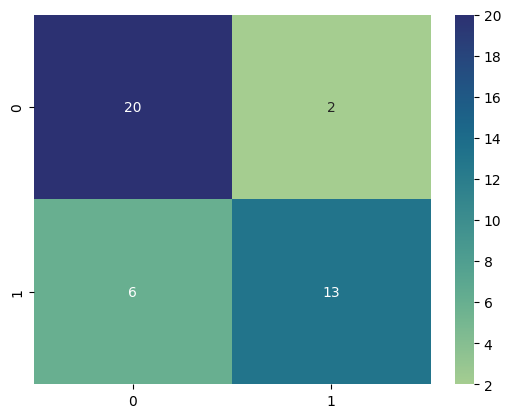

In [ ]:

y_pred_RF = RF_model_emb.predict(testEmb)
cm_RF = confusion_matrix(y_test,y_pred_RF)
sns.heatmap(cm_RF, annot=True, fmt = "d",cmap="crest")
print("Confusion matrix for Random Forest (RF) using fastText embedded vectors")
print(classification_report(y_test,y_pred_RF))


# **Conclusions:**


Last week when using natural language processing techniques such as cleaning using regex, and using text encoding techniques such as counting matrices, TF-IDF matrices and embedded vectors, the Logistic Regression and Random Forest machine learning models showed problems. to be able to predict positive comments since initially there was an imbalance of 89% negative comments and 11% positive comments.

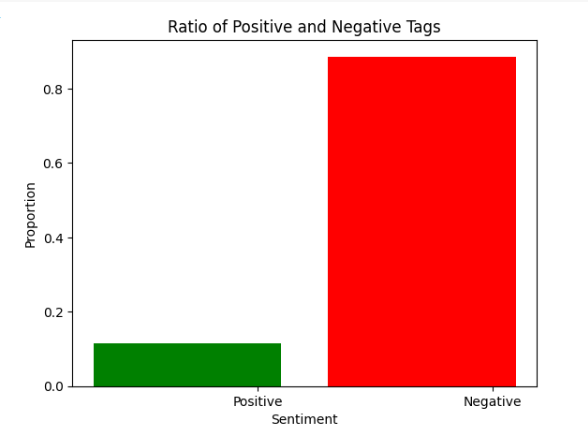

Given this imbalance, it was very obvious that any machine learning model would not be sufficiently capable of detecting positive comments. So for this week the following steps were chosen:

1 - Find more comments about the Jeep brand. Comments from the different vehicles that the Jeep brand has, such as Grand Cherokee, Cherokee, Wrangler, were included to find more positive comments but the result was the same, the system continues to show a large number of negative comments (83%) and a slight increase in positive comments. (17%)

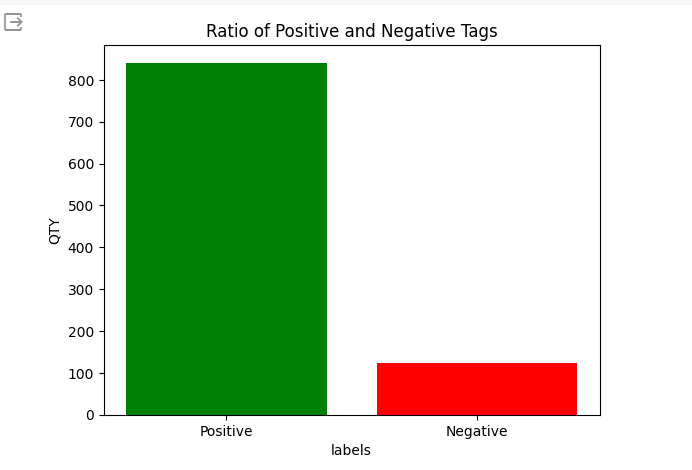

2- Synthetic data generation was performed using a GPT2 transform text generation model to generate comments and balance the model. This solution would only be applied to the training data and the validation or test data would not be touched to avoid the effect of data leakage.
450 positive comments were generated from those already available and 20 negative comments in order to avoid the data leakage effect.
This solution has not been tested with machine learning models.

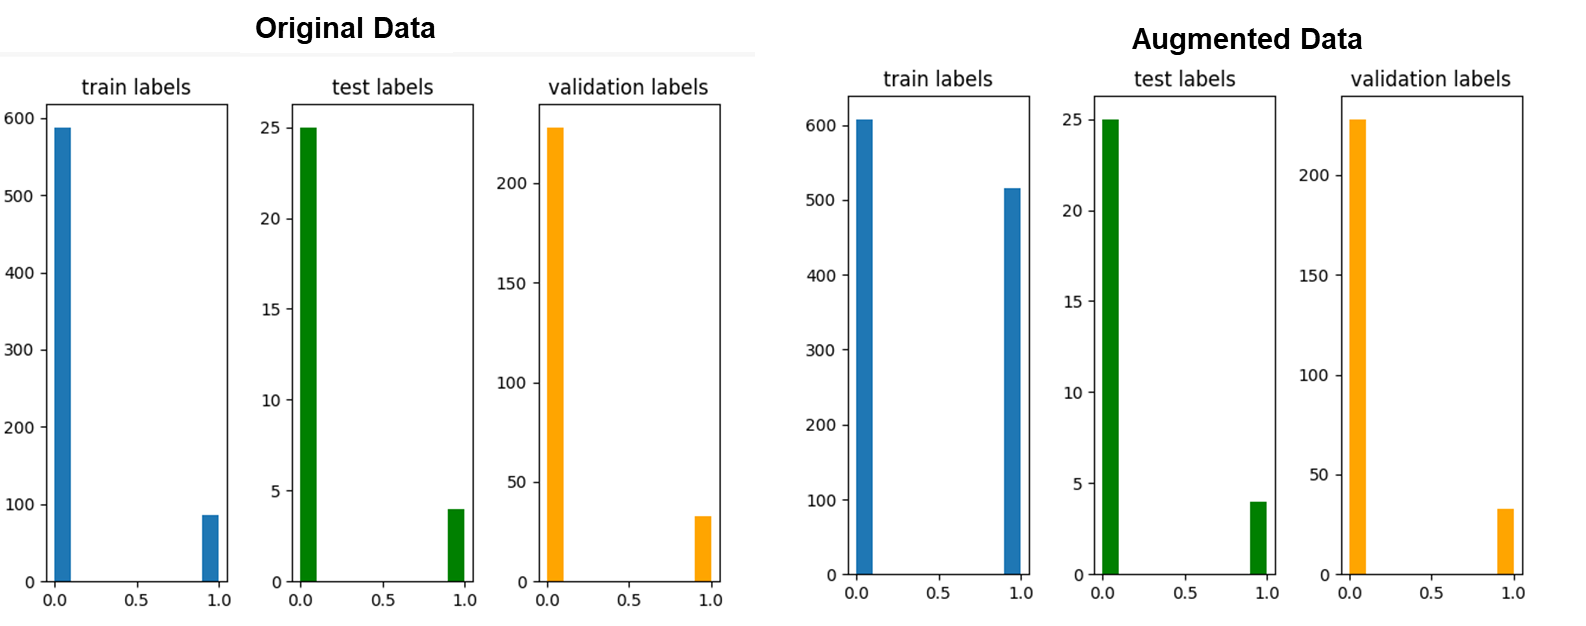

3- The learning model was changed from machine learning models to a “distilbert-base-cased” transformer model to perform the sentiment analysis with a 3-epoch training fine tuning with which both scenarios were tested.
- Using the default training parameters and the original data.
- Using default training parameters and augmented data.

Where the results are very similar, validating the test set “Test” had 100% accuracy, which shows that they are very robust learning models.

In this point I can define that Transformer model “distilbert-base-cased” with fine tuning is my baseline to continues improving to test new data.

**Next activities:**

1- Adjust the parameters of the transformer model trying to improve fine tuning.

2- Test using NLP techniques with the increased data set and check if the result improves. But at this point the transformer proved to be more robust.

3- I am downloading another database of comments about Jeep vehicles and the brand to test the transformer model, how robust it is, it should be noted that it is from a different site and had to be obtained by hand since it does not allow webscrapping.

4- Start with the analysis of topics for positive and negative comments.

# **References:**

- Hugging Face. (s.f.). Text generation strategies. En Hugging Face Transformers Documentation. Recuperado de https://huggingface.co/docs/transformers/en/generation_strategies#diverse-beam-search-decoding

- Liu, X. (s.f.). distilbert-base-multilingual-cased-sentiments-student. Hugging Face. Recuperado de https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student

- Hugging Face. (s.f.). Transformers: Training & Fine-Tuning. Recuperado de https://huggingface.co/docs/transformers/training

- ParseHub. (n.d.). What Is Web Scraping? | ParseHub. ParseHub. Retrieved January 28, 2024, from https://www.parsehub.com/blog/what-is-web-scraping/

- Falcón Morales, L. E. (2023). Maestría en Inteligencia Artificial Aplicada. ITESM

- Kumar Mukhiya, S., y Ahmed, U. (2020). Hands-On Exploratory Data Analysis with Python. Packt Publishing.

- Falcón Morales, L. E. (2023). Expresiones regulares (regex). Maestría en Inteligencia Artificial Aplicada. ITESM.

- KeepCoding. (2023). ¿Qué es el count vectorizer?. https://keepcoding.io/blog/que-es-el-count-vectorizer/#:~:text=El%20count%20vectorizer%20es%20una,de%20a%20nivel%20de%20token.

- KeepCoding. (2023). ¿Qué es el TF-IDF Vectorizer?. https://keepcoding.io/blog/que-es-el-algoritmo-tf-idf-vectorizer/#:~:text=El%20TF%2DIDF%20tiene%20en,de%20TF%2DIDF%20Vectorizer%20bajo.

- Facebook. (2022). Get started. https://fasttext.cc/docs/en/support.html

- Introduction to word embeddings – word2vec, glove, FastText and Elmo. Data Science Machine Learning Deep Learning. (n.d.). https://www.alpha-quantum.com/blog/word-embeddings/introduction-to-word-embeddings-word2vec-glove-fasttext-and-elmo/